In [1]:
import matplotlib.pyplot as plt
import numpy as np

import kim_forger_detailed_model as kf
import numpy as np

class PODResult:
    def __init__(self, projection_matrix, eigenvalues, covariance_matrix):
        self.projection_matrix =projection_matrix 
        self.eigenvalues = eigenvalues 
        self.covariance_matrix = covariance_matrix

def standard_normalize(x: np.ndarray, axis: int = 0) -> np.ndarray:
    """
    Standardize a given array x to have zero mean and unit variance.

    Args:
        x: A NumPy array to be standardized.

    Returns:
        x_normalized: A NumPy array with the same shape as x, but standardized.
    """
    x_swap = x.swapaxes(0, axis)
    # !! NB: the axis=0 is correct. The broadcasting works easiest on axis 0 here
    #        hence why we do .swapaxes(0, axis) at the start + end of the routine.
    x_normalized = (x_swap - np.mean(x_swap, axis=0)) / np.std(x_swap, axis=0)
    return x_normalized.swapaxes(0, axis)

def pod(X, num_modes) -> PODResult:
    """
    Performs Proper Orthogonal Decomposition (POD) on a given snapshot matrix X.

    Args:
        X: A NumPy array of shape (num_vars, num_snapshots), where each column
           represents a snapshot of the system's state variables.
        num_modes: The number of dominant modes to retain.

    Returns:
        result: A PODResult object containing the following fields:
            projection_matrix: A NumPy array of shape (num_vars, num_modes) containing
                the POD modes as columns.
            eigenvalues: A NumPy array of shape (num_modes,) containing the eigenvalues
                corresponding to each mode.
            covariance_matrix: A NumPy array of shape (num_vars, num_vars) containing
                the covariance matrix of the snapshot matrix X.
    """
    
    # 1. Snapshot Matrix, normalized
    X_std = standard_normalize(X, axis=1)
    
    # 2. Covariance Matrix
    C = np.cov(X_std) 

    # 3. Eigenvalue Decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(C) 

    # 4. Mode Selection (Sort in descending order of eigenvalues)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors = eigenvectors[:, :num_modes]  # Keep only the desired number of modes

    return PODResult(
        projection_matrix=eigenvectors, 
        eigenvalues=eigenvalues, 
        covariance_matrix=C)



In [3]:
# Performs the simulations. At the end of this, we will have `n_points` of time and the corresponding state variables,  shape `(180, n_points)`
t_end = 56
n_points = 1000
t, y = kf.main(num_points=n_points, t_end=t_end)

done


In [4]:

# Example Usage (Assuming your data is in X)
num_vars, num_snapshots = y.shape
num_modes_to_keep = num_vars // 3  # Choose based on your analysis

pod = pod(y, num_modes_to_keep)

# Reduced-Order Representation
y_reduced = pod.projection_matrix.T @ y  # Project onto the dominant modes


In [5]:
y_reduced.shape

(60, 1000)

In [6]:
C = pod.covariance_matrix

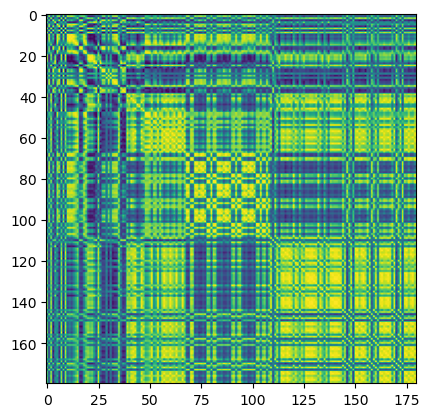

In [7]:
plt.imshow(C)